# EBM Project Notebook
Now that we have learned how to use the EBM package, we are going to 
take the ADNI data set that we cleaned from the last project notebook
and use it to replicate the results from the brain paper from Alex Young.

As a reminder, here are the features we are going to use:
* Cerebrospinal Fluid (CSF) INNO-BIA AlzBio3 immunoassay ('INNO')
  * Amyloid Beta 1-42
  * phosphorylated tau - log transformed to improve normality
  * total tau - log transformed to improve normality
* Volumetric measurements from **1.5T** magnetic resonance imaging (MRI), 
normalised by dividing by Intracranial Volume (ICV)
  * Whole brain volume
  * Ventricular volume
  * Entorhinal cortex volume
  * Hippocampal volume
  * Middle temporal cortex volume
  * Fusiform cortex volume 
* Direct measurements of atrophy between two timepoints using volumetric MRI
  * Annualised whole brain atrophy between 0 and **12 months** using Boundary Shift Integral (BSI)
  * Annualised hippocampal atrophy between 0 and **12 months** using Boundary Shift Integral (BSI)
* Cognitive measures
  * Mini mental state examination (MMSE)
  * ADAS-COG13
  * Rey Auditory Verbal Learning Test (RAVLT)

In [11]:
# Put any import steps that you want to keep here

%matplotlib inline
import os
import numpy as np
import pandas as pd
from scipy import stats 
import matplotlib.pyplot as plt
from kde_ebm.mixture_model import fit_all_kde_models, fit_all_gmm_models
from kde_ebm.plotting import mixture_model_grid, mcmc_uncert_mat, mcmc_trace, stage_histogram
from kde_ebm.mcmc import mcmc, parallel_bootstrap, bootstrap_ebm, bootstrap_ebm_fixedMM, bootstrap_ebm_return_mixtures
import kde_utils 

## Step 1 - Open the data
First up, load up the spreadsheet that you created from the second project notebook.

In [12]:
# Your answer to Step 1
# Below put your code that will load in the data that you created from the ADNI data

data_root = "/Users/catriona/src/TeamCoders/EBM/TeamCoders_Event_Based_Model/Data_Cleaning_And_Wrangling/data/"
df_ebm = pd.read_csv(os.path.join(data_root,'ebm_with_bsifsqc.csv')) #ebm_with_noqc is the one generated by Dave, mine is mine.

## Step 2 - Initial Processing of data
Our spreadsheets from the first exercise still need a few more tweaks before running the EBM.

Our current MRI features are the raw volumes. However, the volume of most brain structures are highly associated with the head size of the individual. We have a good proxy variable of head size extracted from the image data called *total intracranial volume* or TIV. In order to reduce the effect of head size, Young *et al.* divided all of the brain structures by TIV before putting it into the EBM. So remember to do the same with your features. 
However, there are two exceptions. The *boundary shift integral* or BSI measures do not measure the size of the brain structure but how much the size has **changed** over one year. These changes have not been shown to be associated with TIV and so they **do not** need to be normalised by TIV before the EBM.

We will discuss this further in future steps, but we need to have a column that provides a special coding of the three values in the baseline diagnosis (`DX_bl`) column, where:
* Cognitively Normal (CN) = 0
* Alzheimer's Disease (AD) = 1
* Mild Cognitive Impairment (LMCI) = 2

Also, I would suggest to make some Python lists to help hold key sets of column names:
* Key *metadata* that are helpful for processing but not going to be in the EBM, and 
* names of *features* that you want to include in the EBM ordering. 

In [13]:
# Your answer to Step 2

##create a new column for DX_code with 0, 1, 2
df_ebm['DX_code'] = df_ebm['DX_bl'].apply(lambda x: 0 if x == 'CN' else 1 if x == 'AD' else 2 if x == 'LMCI' else 4)

In [14]:
# creating helpful lists of metadata variables and feature variables
## which columns are the MRI volumes? which is the TIV?
##TIV is probably ICV (intracranial volume) as TIV is not there.

## create list of MRI volumes
MRI_vols = ['WholeBrain', 'Ventricles', 'Entorhinal', 'Hippocampus', 'MidTemp', 'Fusiform']

## create list of EBM vars
other_vars = ['TAU_INNO', 'ABETA_INNO', 'PTAU_INNO', 'ANN_BBSI', 'ANN_HBSI', 'MMSE', 'ADAS13', 'RAVLT_immediate']
features = MRI_vols + other_vars

## create list of metadata vars
all_cols = df_ebm.columns.tolist()
key_meta = ['RID', 'DX_code', 'APOE4', 'AGE', 'PTGENDER']
other_meta = [x for x in all_cols if x not in key_meta + features] #this is called list comprehension: new_list = [expression for item in iterable if condition]

In [15]:
# Below put your code for normalising the MRI volumes by TIV
## create new DF where MRI volumes are normalised by TIV and everything else is the same

df_ebm_norm = df_ebm.copy()
df_ebm_norm[MRI_vols] = df_ebm[MRI_vols].div(df_ebm['ICV'], axis=0)

# change column headings for MRI metrics to indicate normalised
df_ebm_norm.rename(columns={'WholeBrain': 'WholeBrain_Norm', 'Ventricles': 'Ventricles_Norm', 'Entorhinal': 'Entorhinal_Norm', 'Hippocampus': 'Hippocampus_Norm', 'MidTemp': 'MidTemp_Norm', 'Fusiform': 'Fusiform_Norm'}, inplace=True)

#reassign features
MRI_vols_norm = ['WholeBrain_Norm', 'Ventricles_Norm', 'Entorhinal_Norm', 'Hippocampus_Norm', 'MidTemp_Norm', 'Fusiform_Norm']
features = MRI_vols_norm + other_vars

## Step 3 - Visualise distributions of features
For each of the features, produce a plot showing the difference between the CN, LMCI, and AD groups.

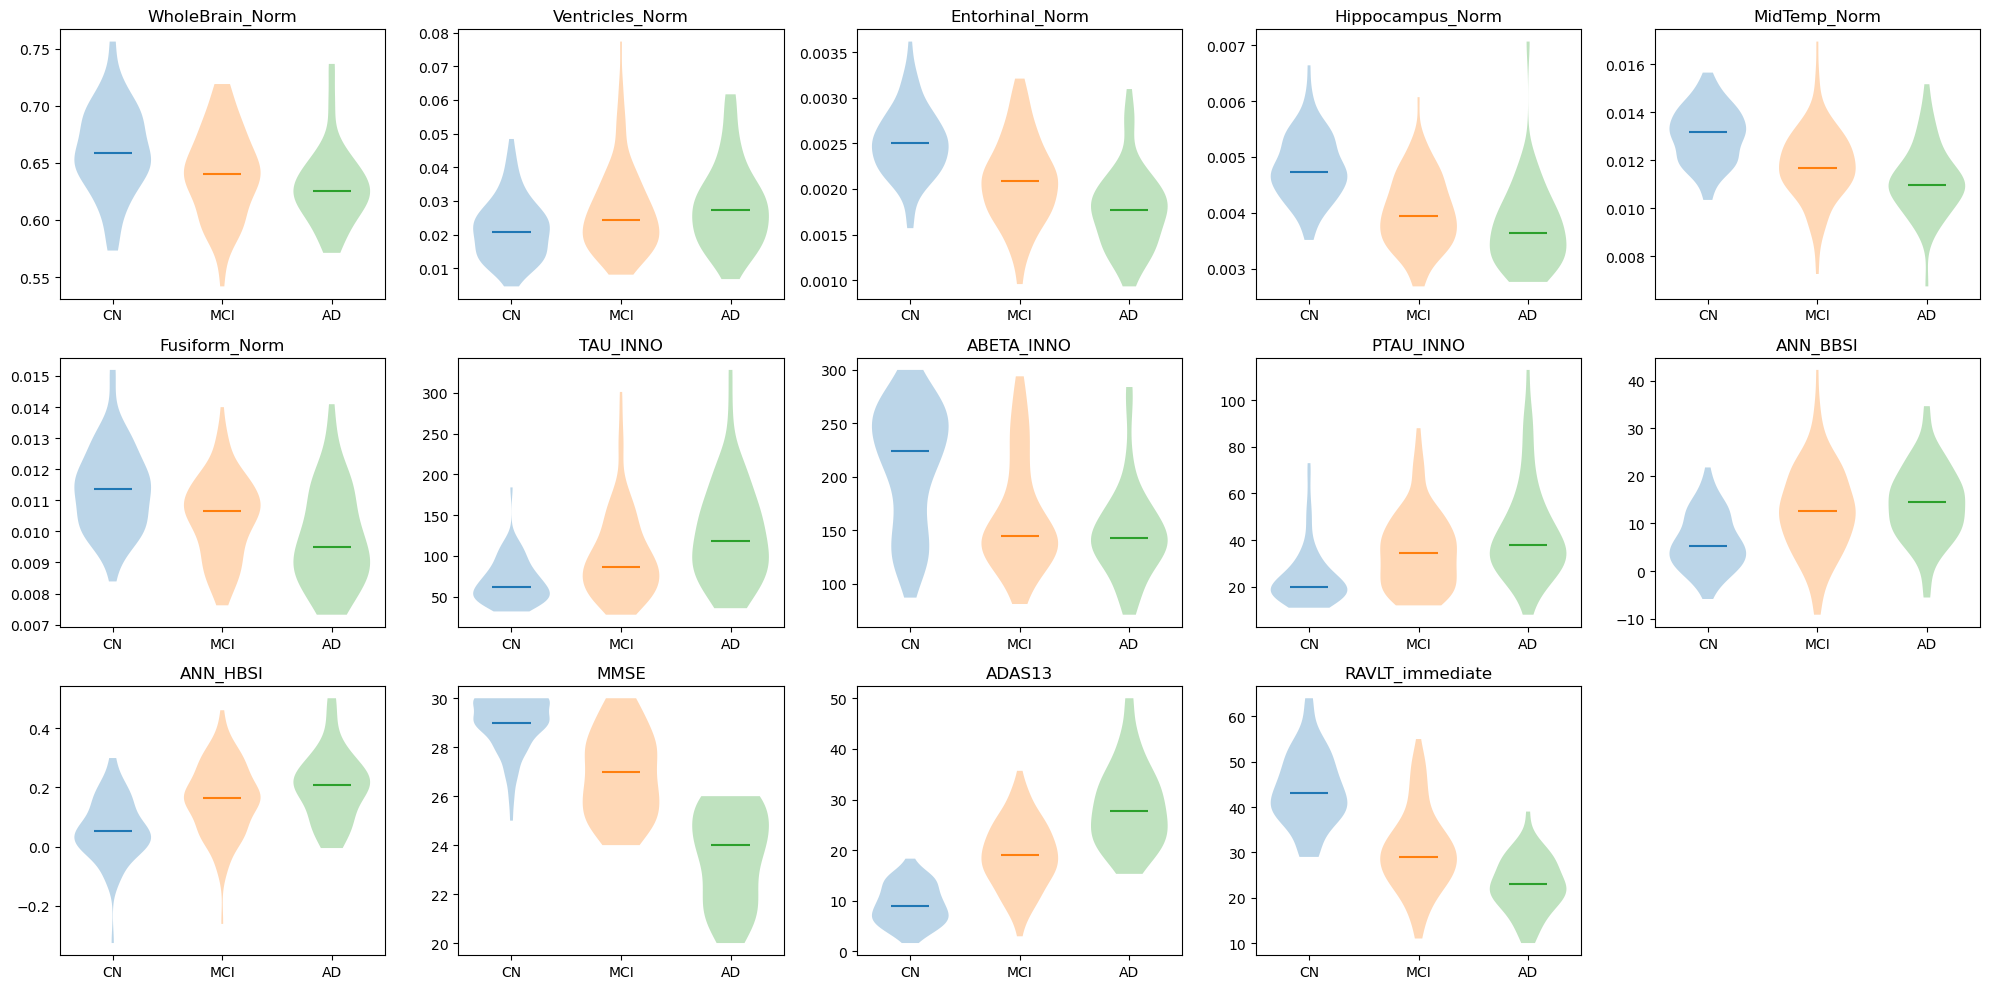

In [16]:
# Your answer to Step 3
# Below put your code for visualising the differences in each features according to disease diagnosis
##plot each feature with diagnosis in a different colour on a single scatter plot, with a different plot for each feature
df_cn = df_ebm_norm[df_ebm_norm['DX_code'] == 0]
df_mci = df_ebm_norm[df_ebm_norm['DX_code'] == 2]
df_ad = df_ebm_norm[df_ebm_norm['DX_code'] == 1]

# Determine the number of data columns
num_df_columns = len(features)
num_plot_cols = 5
num_plot_rows = (num_df_columns // num_plot_cols) + (num_df_columns % num_plot_cols > 0)  # Calculate the number of rows

# Create a figure and axes using subplots
fig, axes = plt.subplots(num_plot_rows, num_plot_cols, figsize=(20, 10))

# Flatten the axes array if needed
axes = axes.flatten()

# Loop over the column names and create subplots
for i, column in enumerate(features):
    # Select the current axis for the subplot
    ax = axes[i]

    # Plot the column data
    plots = ax.violinplot(df_cn[column], positions=[1], showmedians=True, widths=0.7, showextrema=False)
    plots = ax.violinplot(df_mci[column], positions=[2], showmedians=True, widths=0.7, showextrema=False)
    plots = ax.violinplot(df_ad[column], positions=[3], showmedians=True, widths=0.7, showextrema=False)

    # Set the title and labels for each subplot
    ax.set_title(column)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['CN', 'MCI', 'AD'])


# Remove any unused subplots
if len(features) < len(axes):
    for ax in axes[len(features):]:
        ax.remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Step 4 - Statistical tests
After you have visually inspected the data, perform some statistical tests in order to assess whether there is evidence that these groups are significantly different from each other.  Remember there are three groups,with the most important comparison for ensuring that there is a disease-specific signal is CN vs AD (as MCI may be caused by AD or other etiologies.)

In [17]:
# Your answer to Step 4
# Below put your code for basic statistical analysis testing the difference in feature
# values between groups 

print('Mann Whitney U-test:\n')

for i, column in enumerate(features):
    x_c = df_cn[column]
    x_p = df_ad[column]
    effect_size = np.absolute(np.median(x_p)-np.median(x_c))/stats.median_abs_deviation(x_c)
    u,p = stats.mannwhitneyu(x_c,x_p)
    print('%s\n - effect size = %.3g\n - u = %i, p = %.2g\n' % (column,effect_size,u,p))
    
#All statistical tests show substantial evidence of a difference between patients and controls, so they can all be included in the EBM. 
#As expected, the biomarkers that become abnormal earliest in the disease process have more abnormal values and thus the effect size is the largest (and the p-value is the smallest, as would be expected) in these biomarkers. 

Mann Whitney U-test:

WholeBrain_Norm
 - effect size = 1.28
 - u = 3134, p = 8.2e-07

Ventricles_Norm
 - effect size = 1.05
 - u = 1354, p = 0.0007

Entorhinal_Norm
 - effect size = 3.08
 - u = 3749, p = 5.9e-15

Hippocampus_Norm
 - effect size = 2.57
 - u = 3709, p = 2.6e-14

MidTemp_Norm
 - effect size = 2.28
 - u = 3533, p = 1.1e-11

Fusiform_Norm
 - effect size = 1.92
 - u = 3231, p = 7.3e-08

TAU_INNO
 - effect size = 3.32
 - u = 742, p = 4.2e-10

ABETA_INNO
 - effect size = 2.09
 - u = 3287, p = 1.6e-08

PTAU_INNO
 - effect size = 3.6
 - u = 650, p = 2.4e-11

ANN_BBSI
 - effect size = 2.07
 - u = 856, p = 1.1e-08

ANN_HBSI
 - effect size = 2.54
 - u = 712, p = 1.7e-10

MMSE
 - effect size = 5
 - u = 4133, p = 2.5e-22

ADAS13
 - effect size = 6.28
 - u = 8, p = 3.6e-22

RAVLT_immediate
 - effect size = 4
 - u = 4098, p = 3.5e-21



## Step 5 - Mixture model
In the walkthrough, we used the KDE approach to determine the probability distribution that an event has occurred. However, in the original implementation for the Young *et al.* paper, this was done using a parametric approach with Gaussian Mixture Models. This can be done using the 'fit_all_gmm_models' command instead of the 'fit_all_kde_models' command. Make sure to use the special coding of diagnosis as your labels for the EBM input.

One other difference that is critically important. In the walkthrough we simulated 100 "completely healthy" individuals as controls, i.e. they had no evidence of abnormality in any of the biomarkers. In the ADNI cohort this is not the case. We know that Alzheimer's disease pathology begins very early in the process, in some cases 20 years before signs of cognitive impairment are so pronounces that they would meet the criteria for a diagnosis of probable AD. As a result there are many controls in our group who actually have abnormal biomarkers. This is mentioned in the *Young et al.* paper:
> In sporadic Alzheimer’s disease, however, a significant proportion of the cognitively
> normal control group may have presymptomatic Alzheimer’s disease. To counter this,
> we fitted a mixture of two normal distributions to each biomarker separately using 
> data from all subjects to obtain the two models. To ensure a robust fit, 
> particularly for biomarkers where the distributions of the healthy and diseased 
> population overlap significantly, we constrain the standard deviations so that the 
> standard deviation of P(x|~E_i) and P(x|E_i) is less than or equal to that of the 
> cognitively normal and Alzheimer’s disease group, respectively.

The constraint mentioned above can be implemented in the `fit_all_gmm_models` by setting the function argument `fit_all_subjects` to `True`. This is why we needed to have our labels such that cognitively normals were 0 and AD were 1, so that the constraints would be applied to the correct groups. 

After the mixture models have been fitted for each feature, make sure to take a look at them and see if they make sense.

In [63]:
# Your answer to Step 5
# need to convert dataframes into arrays first

df_all = df_ebm_norm[features].values
codes = df_ebm_norm['DX_code'].values

# df_all = pd.concat([df_cn[features], df_ad[features]], axis=0).values
# codes = pd.concat([df_cn['DX_code'], df_ad['DX_code']], axis=0).values

In [69]:
#run the GMM
gmm_mixtures = fit_all_gmm_models(
    df_all, codes,
    fit_all_subjects=True,
    implement_fixed_controls=False, #this changes the reuslts a lot, nto sure whether it should be true or false
    patholog_dirn=None
)

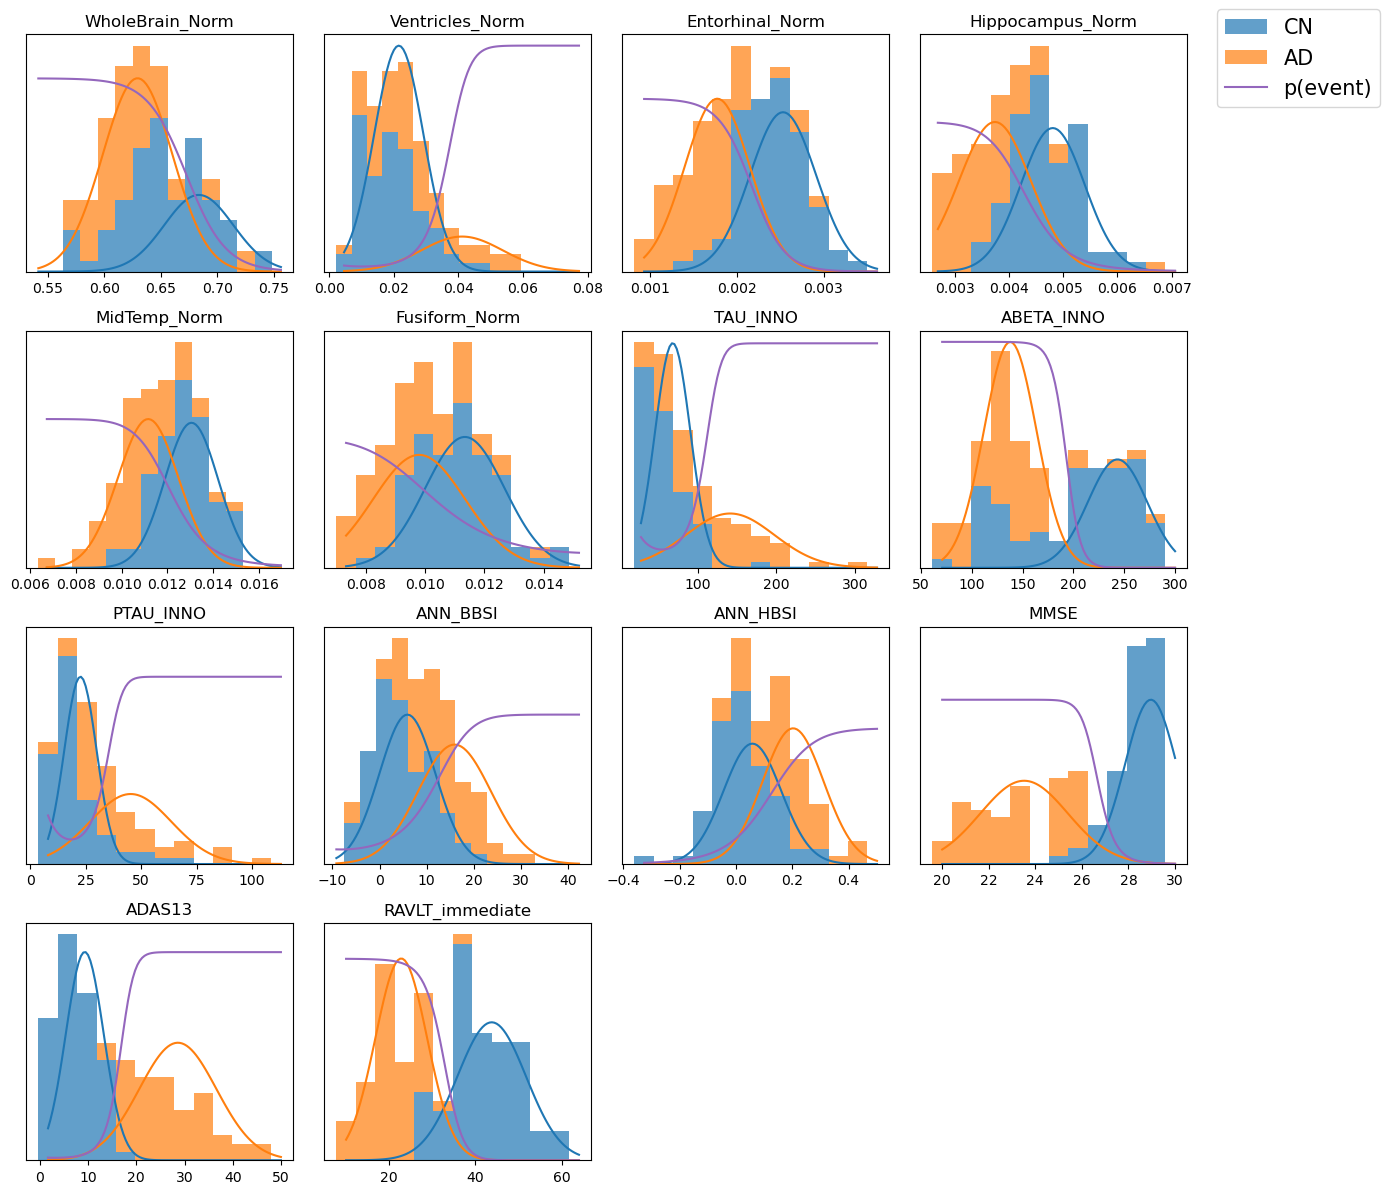

In [72]:
# View the mixture models
fig = mixture_model_grid(
    df_all, codes,
    gmm_mixtures,
    score_names=features,
    class_names=['CN','AD', 'p(event)']
)

## Step 6 - Running the EBM
Now that you have the mixture models, it is time to run the EBM. In the code cell(s) below, please run your MCMC sampling.

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5572.14it/s]


ML order   : WholeBrain_Norm, ABETA_INNO, ANN_BBSI, PTAU_INNO, TAU_INNO, ANN_HBSI, ADAS13, RAVLT_immediate, Entorhinal_Norm, Hippocampus_Norm, MMSE, MidTemp_Norm, Fusiform_Norm, Ventricles_Norm


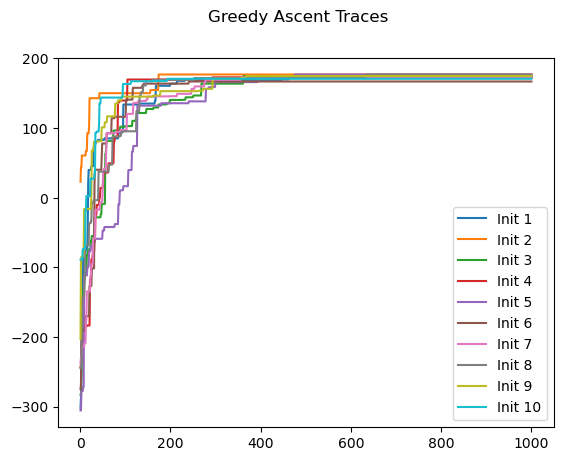

In [73]:
# Your answer to Step 6
# Below put your code for performing the MCMC sampling
# and print out the most likely sample

#* Perform MCMC sequencing and store results in mcmc_samples
mcmc_samples = mcmc(df_all, gmm_mixtures)

#* Obtaine the maximum Likelihood sequence over all samples
seq_ml = mcmc_samples[0].ordering

# print('ML sequence: {0}'.format(seq_ml))
print('ML order   : %s' % ', '.join([features[k] for k in seq_ml]))

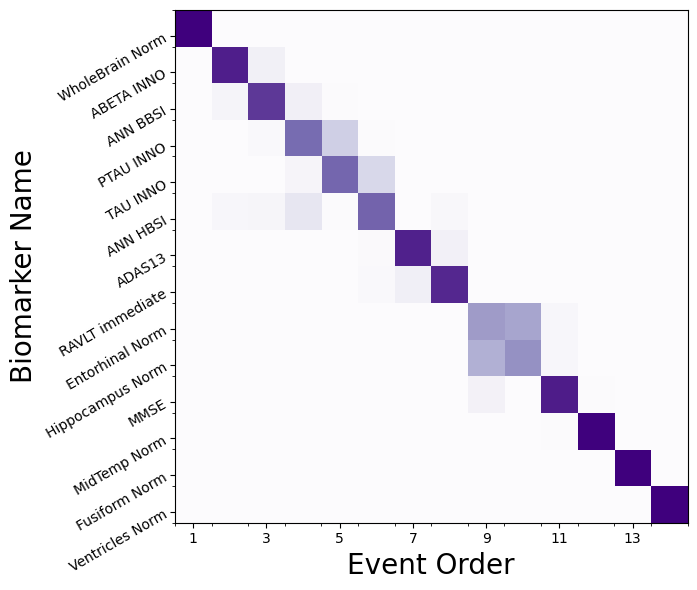

In [74]:
# View the ML posterior
f,a = mcmc_uncert_mat(mcmc_samples, ml_order=None, score_names=features)

In [75]:
# Save in a dict()
ebm_results = {"mixtures": gmm_mixtures, "mcmc_samples": mcmc_samples, "sequence_ml": seq_ml}

## Step 7 - Positional Variance Diagram
Perform the necessary steps to get the positional variance diagram. Which features are we confident of their position and which ones are we not? Does your positional variance diagram coincide with the paper? In what ways are they different? What are the best practices for producing a PVD.

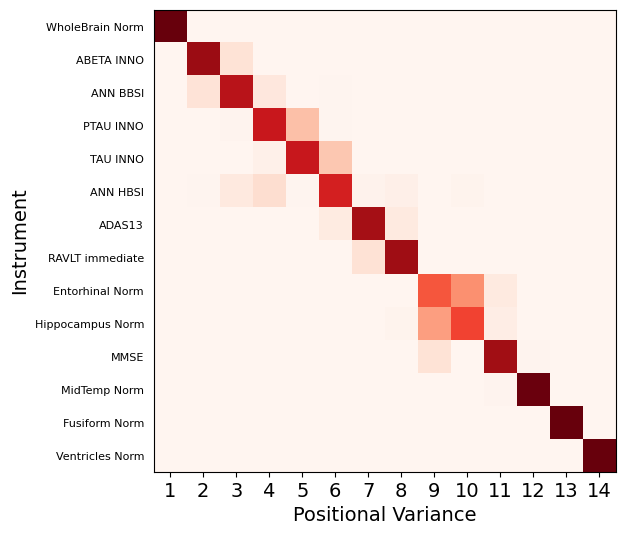

In [23]:
# Your answer to Step 7
# Below put your code for producing the positional variance diagram

import kde_utils 
nom = 'tute'
#* Plot EBM (PVD)
pvd_ml, seq_ml = kde_utils.extract_pvd(ml_order=seq_ml,samples=mcmc_samples)
reorder_ml = np.argsort(seq_ml)
pvd_ml_ = pvd_ml[:][reorder_ml]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = features
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_ml]
ax.imshow(pvd_ml_[:][seq_ml], interpolation='nearest', cmap='Reds')

n_biomarkers = pvd_ml.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0.0)
ax.tick_params(axis='y',color='w')
labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=8)
ax.set_ylabel('Instrument', fontsize=14)
ax.set_xlabel('Positional Variance', fontsize=14)
ax.grid(False)

kde_utils.save_plot(fig, nom+"-PVD_ML")

## Step 8 - Staging
Validate this data by looking at the stages of each individual. What stages are the controls in? What does the staging of the MCI look like compared to the dementia.

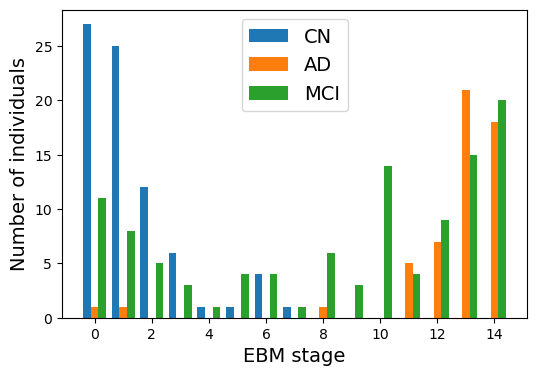

In [24]:
# Your answer to Step 8
# Below put your code for performing the staging analysis of your data

#* Staging
#* Maximum-likelihood model stage: could include longitudinal data, including followups not used to train the EBM
prob_mat_ml, stages_long_ml, stage_likelihoods_long_ml, stages_long_ml_expected = kde_utils.ebm_staging(
    x=df_all,
    mixtures=gmm_mixtures,
    samples=mcmc_samples
)

stages_long = stages_long_ml

fig, ax = plt.subplots(figsize=(6,4))

ax.hist([stages_long[codes==0], stages_long[codes==1],stages_long[codes==2]],bins=np.arange(-0.5,len(features)+1.5,1))
ax.set_xlabel('EBM stage',fontsize=14)
ax.set_ylabel('Number of individuals',fontsize=14)
leg = ax.legend(['CN','AD','MCI'],fontsize=14)

## Step 9 - Explore
**Congratulations** you have succeeded in the Team Coders task! Now the goal is to take what you have learned and think about what questions you would like to answer with the EBM. What other analyses were done in the paper? What things could we change?
Here are some potential things you may want to try:
* Using the KDE method of mixture modelling, how does the ordering change. Looking at what we have stated in Step 5, why might these orderings be different
* Look at specific populations, say individuals who have the risk gene *APOE* $\epsilon4$ ?
* Try more principled methods of uncertainty using cross-fold validation.

In [43]:
# Your answer to STep 9
# Below put the additional experiments that you have tried and 
# summarize the findings as part of the presentation.

#USING KDE METHOD

event_disease_direction_dict = {'WholeBrain_Norm':-1, 'Ventricles_Norm':-1, 'Entorhinal_Norm':-1, 'Hippocampus_Norm':-1, 'MidTemp_Norm':-1, 'Fusiform_Norm':-1, 'TAU_INNO':1, 'ABETA_INNO':-1, 'PTAU_INNO':1, 'ANN_BBSI':1, 'ANN_HBSI':1, 'MMSE':-1, 'ADAS13':1, 'RAVLT_immediate':-1}
event_disease_direction = [event_disease_direction_dict[f] for f in features]

#run the GMM
kde_mixtures = fit_all_kde_models(
    df_all, codes,
    # fit_all_subjects=True,
    # implement_fixed_controls=True,
    patholog_dirn_array=event_disease_direction
)

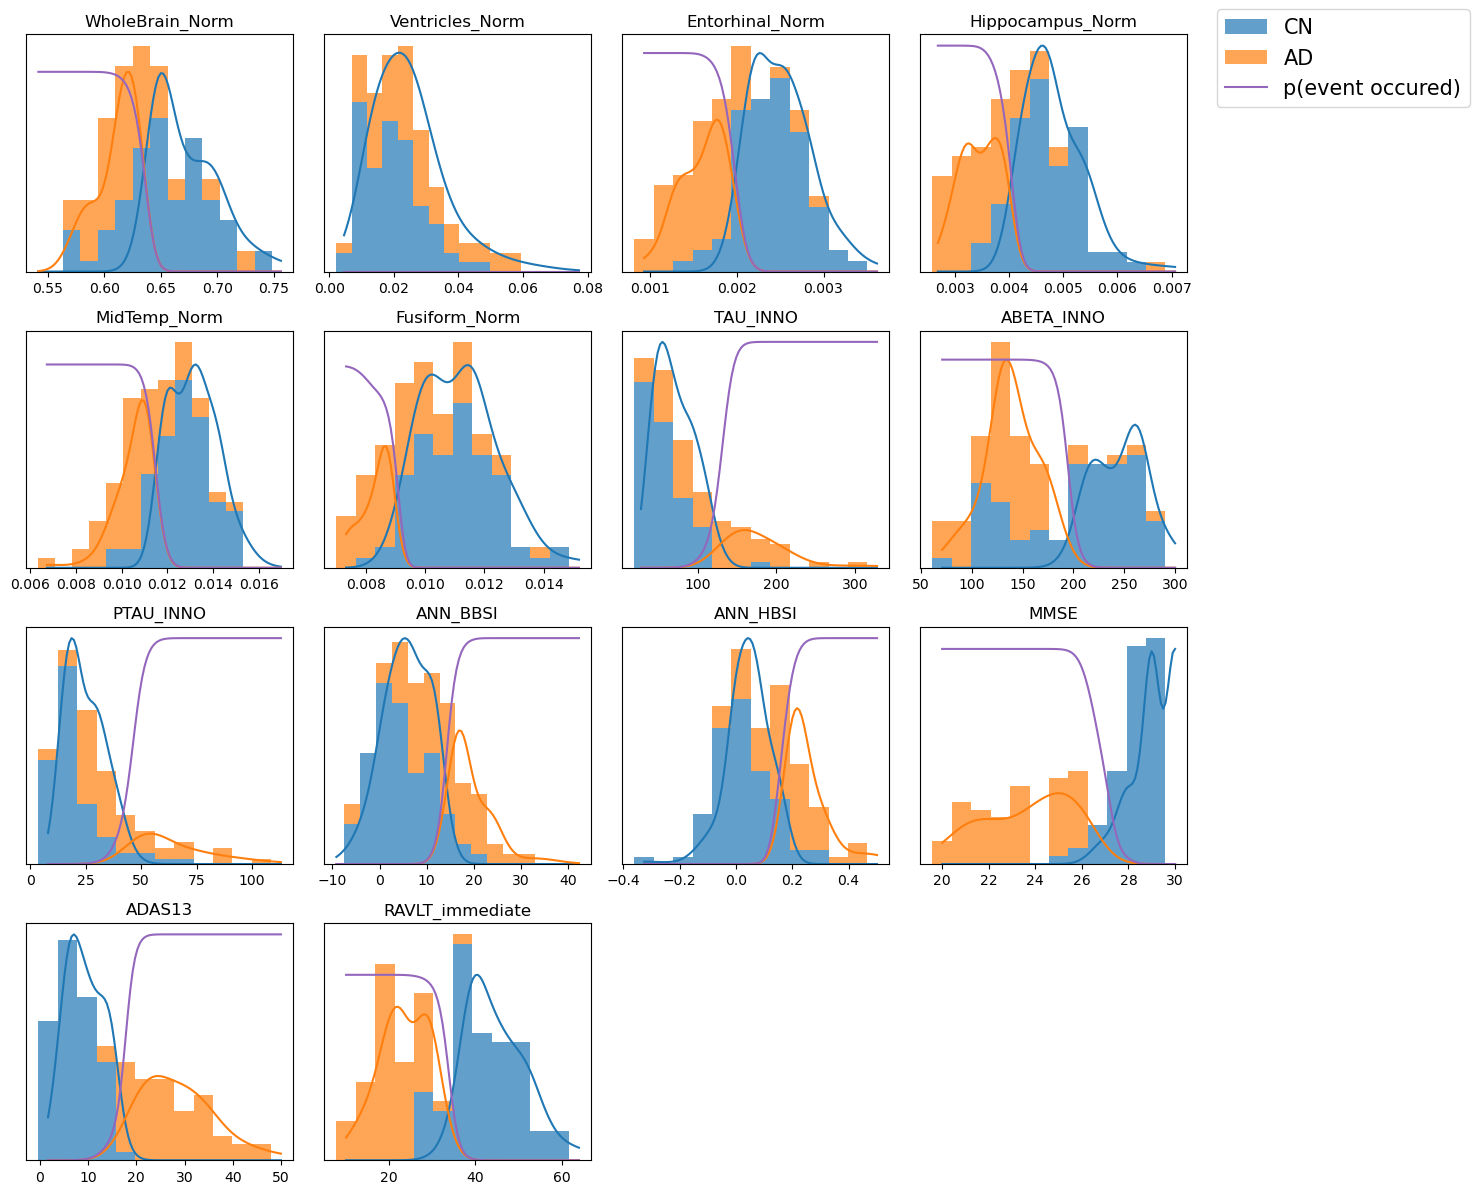

In [44]:
# View the mixture models
fig = mixture_model_grid(
    df_all, codes,
    kde_mixtures,
    score_names=features,
    class_names=['CN','AD']
)

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5592.02it/s]


ML order   : ABETA_INNO, RAVLT_immediate, ADAS13, MMSE, ANN_HBSI, Hippocampus_Norm, Entorhinal_Norm, MidTemp_Norm, WholeBrain_Norm, ANN_BBSI, PTAU_INNO, TAU_INNO, Fusiform_Norm, Ventricles_Norm


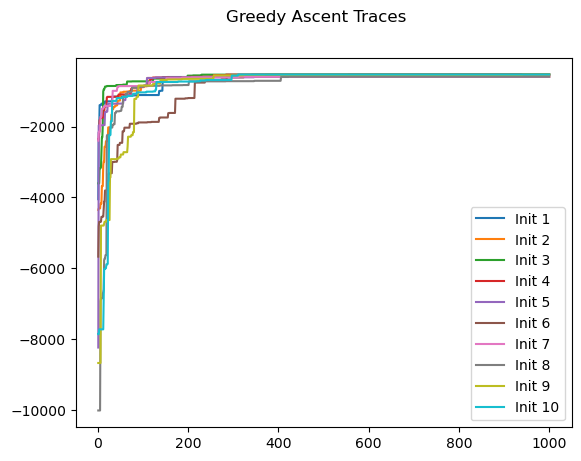

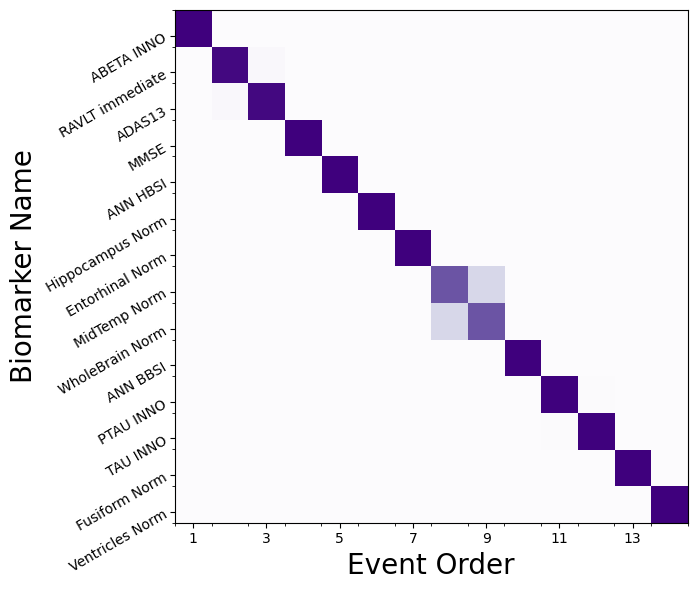

In [40]:
# Your answer to Step 6
# Below put your code for performing the MCMC sampling
# and print out the most likely sample

#* Perform MCMC sequencing and store results in mcmc_samples
mcmc_samples_2 = mcmc(df_all, kde_mixtures)

#* Obtaine the maximum Likelihood sequence over all samples
seq_ml_2 = mcmc_samples_2[0].ordering

# print('ML sequence: {0}'.format(seq_ml))
print('ML order   : %s' % ', '.join([features[k] for k in seq_ml_2]))

# View the ML posterior
f,a = mcmc_uncert_mat(mcmc_samples_2, ml_order=None, score_names=features)

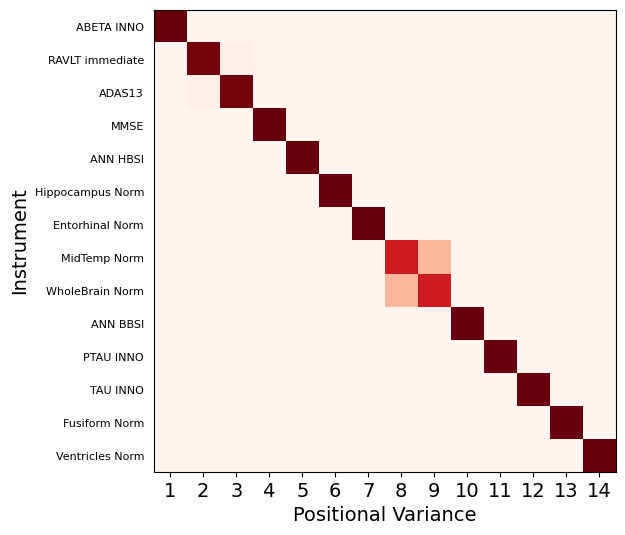

In [42]:
# Save in a dict()
ebm_results_2 = {"mixtures": kde_mixtures, "mcmc_samples": mcmc_samples_2, "sequence_ml": seq_ml_2}

# Your answer to Step 7
# Below put your code for producing the positional variance diagram

nom = 'tute'
#* Plot EBM (PVD)
pvd_ml, seq_ml = kde_utils.extract_pvd(ml_order=seq_ml_2,samples=mcmc_samples_2)
reorder_ml = np.argsort(seq_ml)
pvd_ml_ = pvd_ml[:][reorder_ml]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = features
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_ml_2]
ax.imshow(pvd_ml_[:][seq_ml_2], interpolation='nearest', cmap='Reds')

n_biomarkers = pvd_ml.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0.0)
ax.tick_params(axis='y',color='w')
labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=8)
ax.set_ylabel('Instrument', fontsize=14)
ax.set_xlabel('Positional Variance', fontsize=14)
ax.grid(False)

kde_utils.save_plot(fig, nom+"-PVD_ML")

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6517.67it/s]


ML order   : ANN_BBSI, ANN_HBSI, WholeBrain_Norm, PTAU_INNO, TAU_INNO, MidTemp_Norm, ADAS13, RAVLT_immediate, Entorhinal_Norm, Hippocampus_Norm, MMSE, Fusiform_Norm, Ventricles_Norm, ABETA_INNO


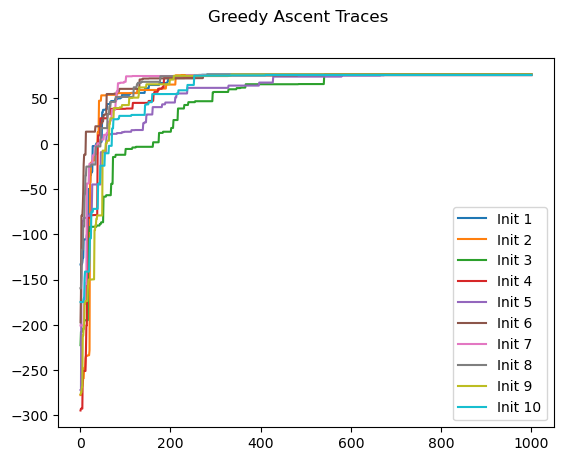

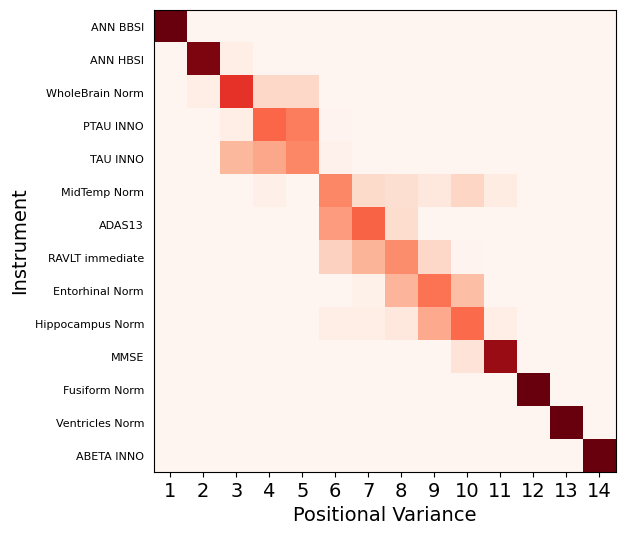

In [130]:
#* Look at specific populations, say individuals who have the risk gene *APOE* $\epsilon4$ ?

df_apoe_0 = df_ebm_norm[df_ebm_norm['APOE4'] == 0]
df_apoe_1 = df_ebm_norm[df_ebm_norm['APOE4'] == 1]
df_apoe_2 = df_ebm_norm[df_ebm_norm['APOE4'] == 2]

a = df_apoe_1[features].values
b = df_apoe_1['DX_code'].values

#run the GMM
gmm_mixtures_apoe = fit_all_gmm_models(
    a, b,
    fit_all_subjects=True,
    implement_fixed_controls=False, #this changes the reuslts a lot, nto sure whether it should be true or false
    patholog_dirn=None
)

# # View the mixture models
# fig = mixture_model_grid(
#     df_all, codes,
#     gmm_mixtures,
#     score_names=features,
#     class_names=['CN','AD', 'p(event)']
# )

# Your answer to Step 6
# Below put your code for performing the MCMC sampling
# and print out the most likely sample

#* Perform MCMC sequencing and store results in mcmc_samples
mcmc_samples_apoe = mcmc(a, gmm_mixtures_apoe)

#* Obtaine the maximum Likelihood sequence over all samples
seq_ml_apoe = mcmc_samples_apoe[0].ordering

# print('ML sequence: {0}'.format(seq_ml))
print('ML order   : %s' % ', '.join([features[k] for k in seq_ml_apoe]))

# # View the ML posterior
# f,a = mcmc_uncert_mat(mcmc_samples_apoe, ml_order=None, score_names=features)

# Save in a dict()
ebm_results_apoe = {"mixtures": gmm_mixtures_apoe, "mcmc_samples": mcmc_samples_apoe, "sequence_ml": seq_ml_apoe}

# Your answer to Step 7
# Below put your code for producing the positional variance diagram

nom = 'tute'
#* Plot EBM (PVD)
pvd_ml, seq_ml = kde_utils.extract_pvd(ml_order=seq_ml_apoe,samples=mcmc_samples_apoe)
reorder_ml = np.argsort(seq_ml_apoe)
pvd_ml_ = pvd_ml[:][reorder_ml]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = features
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_ml_apoe]
ax.imshow(pvd_ml_[:][seq_ml_apoe], interpolation='nearest', cmap='Reds')

n_biomarkers = pvd_ml.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0.0)
ax.tick_params(axis='y',color='w')
labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=8)
ax.set_ylabel('Instrument', fontsize=14)
ax.set_xlabel('Positional Variance', fontsize=14)
ax.grid(False)

kde_utils.save_plot(fig, nom+"-PVD_ML")

/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/awkde/tools.py:73: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = _np.atleast_2d(_np.cov(sam, rowvar=False))
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/

Repeated CV fold 1 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5792.45it/s]


Repeated CV fold 2 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5659.01it/s]


Repeated CV fold 3 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5762.99it/s]


Repeated CV fold 4 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5764.65it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/awkde/tools.py:73: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = _np.atleast_2d(_np.cov(sam, rowvar=False))
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide b

Repeated CV fold 5 of 50


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5299.95it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5349.54it/s]


Repeated CV fold 6 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5584.59it/s]


Repeated CV fold 7 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5658.41it/s]


Repeated CV fold 8 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5647.23it/s]


Repeated CV fold 9 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5736.98it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/awkde/tools.py:73: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = _np.atleast_2d(_np.cov(sam, rowvar=False))
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide b

Repeated CV fold 10 of 50


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3954.88it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5481.26it/s]


Repeated CV fold 11 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5631.59it/s]


Repeated CV fold 12 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5644.34it/s]


Repeated CV fold 13 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5661.80it/s]


Repeated CV fold 14 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5689.13it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/awkde/tools.py:73: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = _np.atleast_2d(_np.cov(sam, rowvar=False))
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide b

Repeated CV fold 15 of 50


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5885.72it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5744.53it/s]


Repeated CV fold 16 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5660.01it/s]


Repeated CV fold 17 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5716.70it/s]


Repeated CV fold 18 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5622.85it/s]


Repeated CV fold 19 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5616.57it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/awkde/tools.py:73: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = _np.atleast_2d(_np.cov(sam, rowvar=False))
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide b

Repeated CV fold 20 of 50


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5692.08it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/plotting/plotting.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5675.63it/s]


Repeated CV fold 21 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5628.30it/s]


Repeated CV fold 22 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5727.71it/s]


Repeated CV fold 23 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5741.82it/s]


Repeated CV fold 24 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5709.87it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/awkde/tools.py:73: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = _np.atleast_2d(_np.cov(sam, rowvar=False))
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide b

Repeated CV fold 25 of 50


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5833.45it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5648.79it/s]


Repeated CV fold 26 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5679.03it/s]


Repeated CV fold 27 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5662.57it/s]


Repeated CV fold 28 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5691.81it/s]


Repeated CV fold 29 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5772.82it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/awkde/tools.py:73: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = _np.atleast_2d(_np.cov(sam, rowvar=False))
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide b

Repeated CV fold 30 of 50


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5793.03it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5728.63it/s]


Repeated CV fold 31 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5745.96it/s]


Repeated CV fold 32 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5611.18it/s]


Repeated CV fold 33 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5750.85it/s]


Repeated CV fold 34 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5727.42it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/awkde/tools.py:73: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = _np.atleast_2d(_np.cov(sam, rowvar=False))
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide b

Repeated CV fold 35 of 50


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5759.67it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5745.44it/s]


Repeated CV fold 36 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5707.47it/s]


Repeated CV fold 37 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5749.81it/s]


Repeated CV fold 38 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5750.25it/s]


Repeated CV fold 39 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5776.70it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/awkde/tools.py:73: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = _np.atleast_2d(_np.cov(sam, rowvar=False))
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide b

Repeated CV fold 40 of 50


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5808.82it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5719.07it/s]


Repeated CV fold 41 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5757.25it/s]


Repeated CV fold 42 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5733.20it/s]


Repeated CV fold 43 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5760.77it/s]


Repeated CV fold 44 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5774.07it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/awkde/tools.py:73: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = _np.atleast_2d(_np.cov(sam, rowvar=False))
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide b

Repeated CV fold 45 of 50


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5802.49it/s]
/Users/catriona/opt/anaconda3/envs/teamcoder_ebm/lib/python3.7/site-packages/kde_ebm/mcmc/mcmc.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5753.45it/s]


Repeated CV fold 46 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5826.22it/s]


Repeated CV fold 47 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5746.21it/s]


Repeated CV fold 48 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5751.44it/s]


Repeated CV fold 49 of 50


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5737.79it/s]


Repeated CV fold 50 of 50


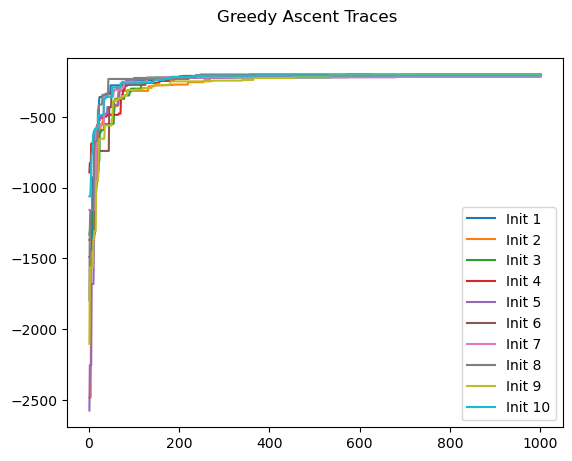

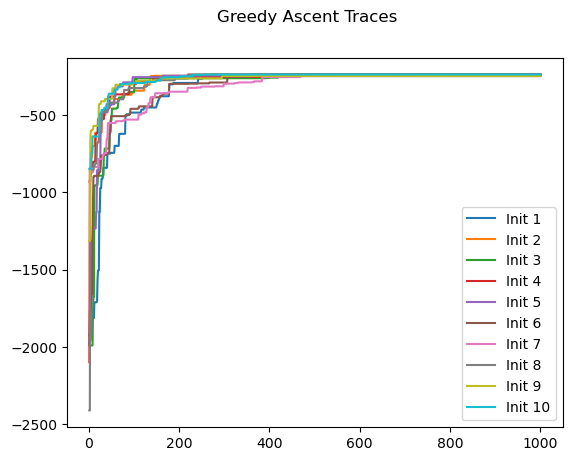

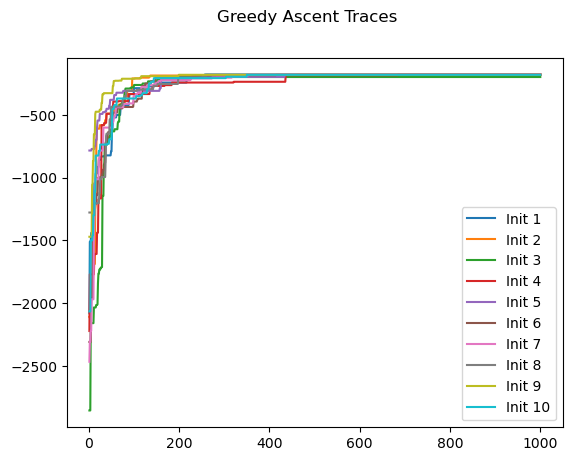

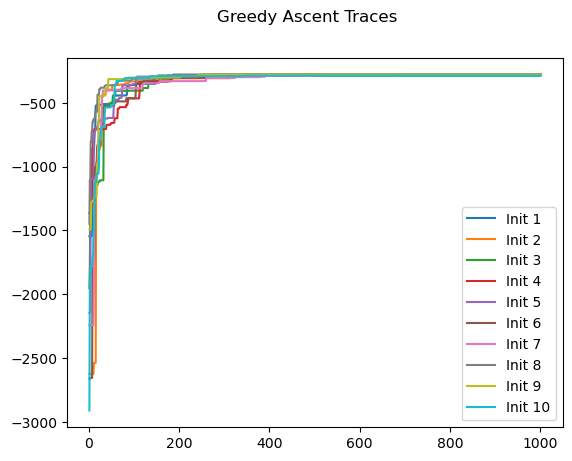

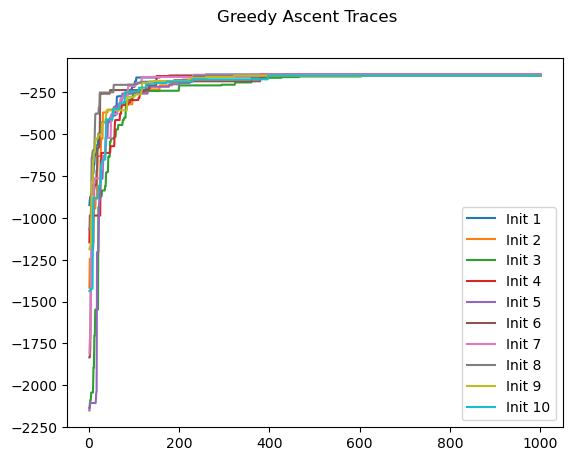

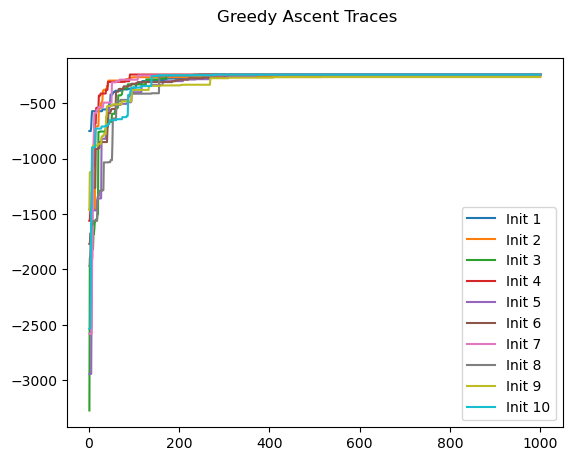

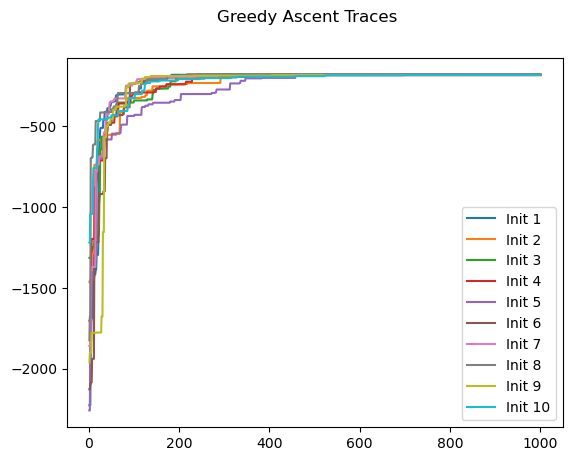

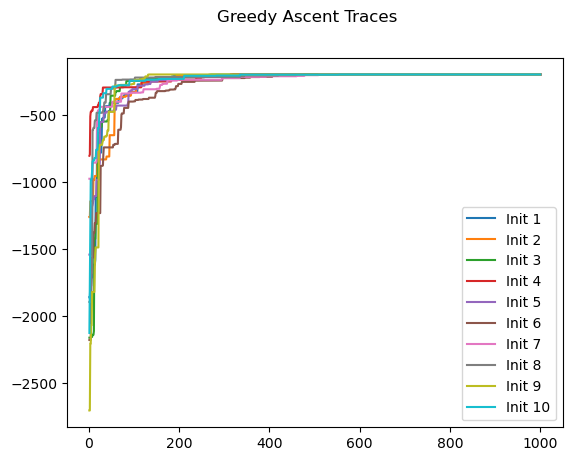

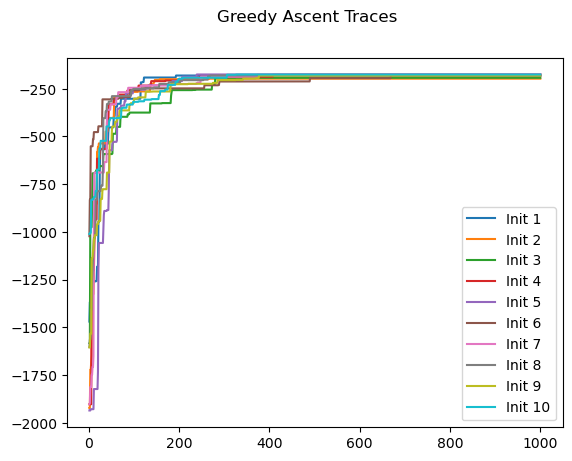

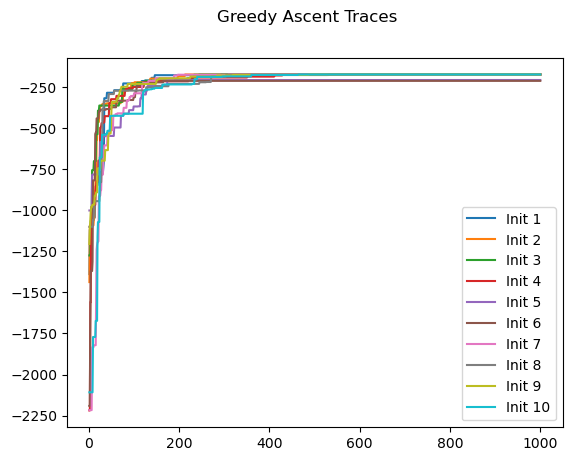

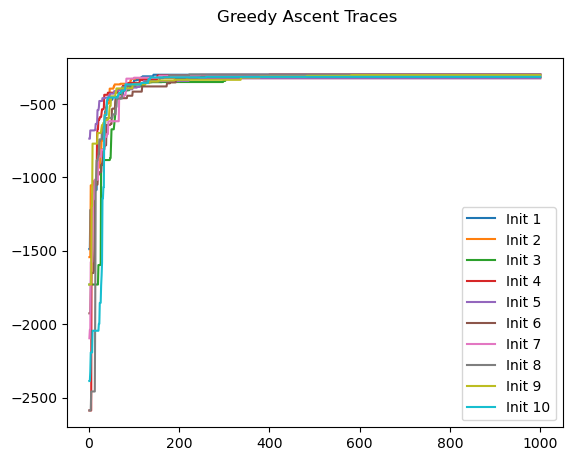

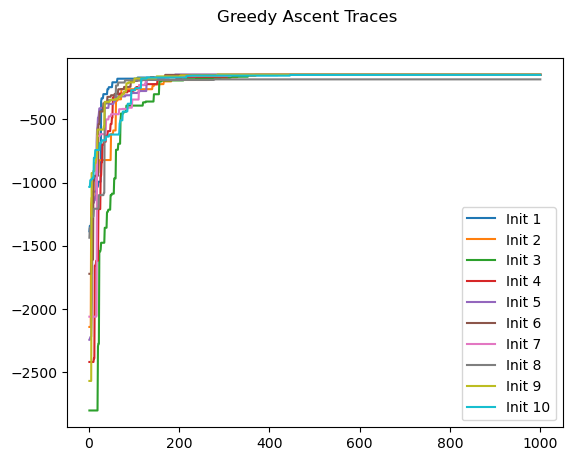

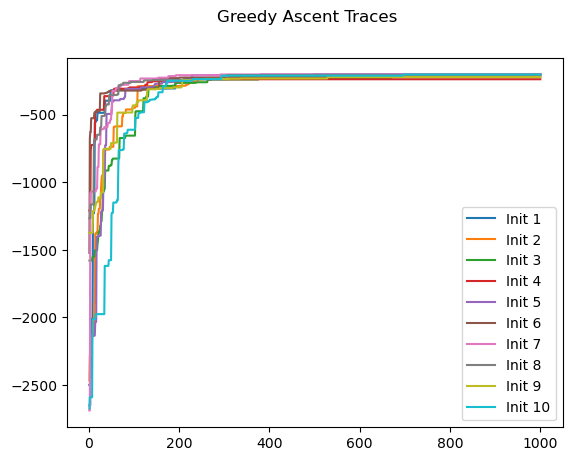

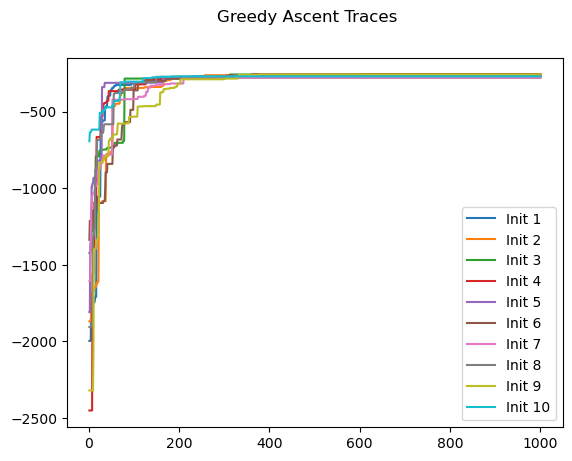

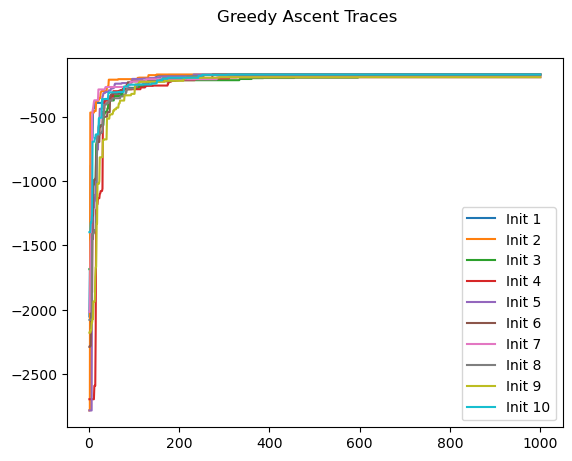

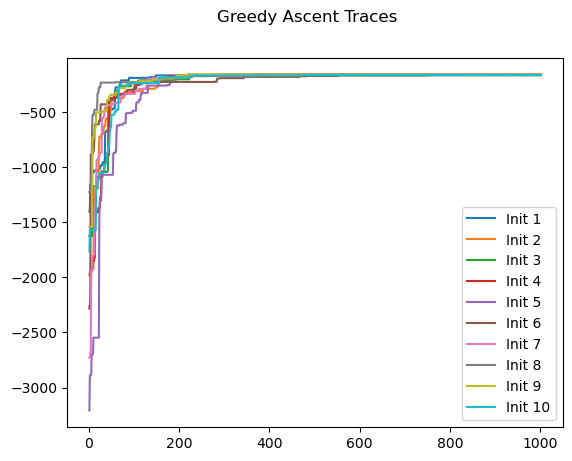

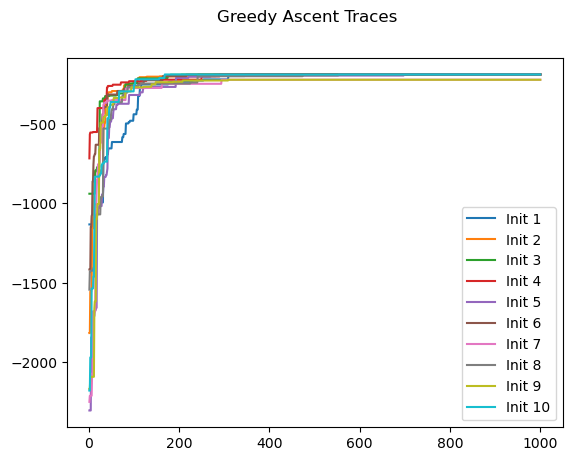

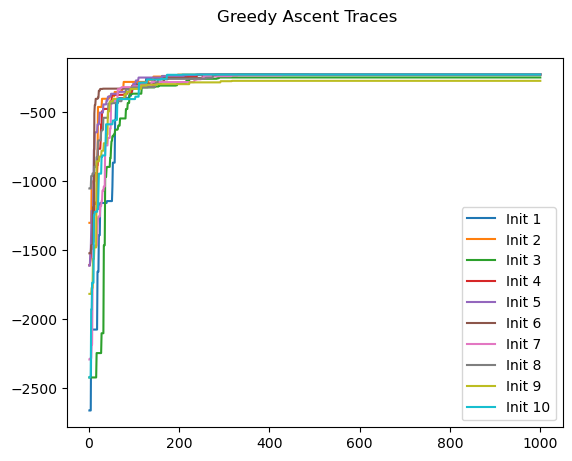

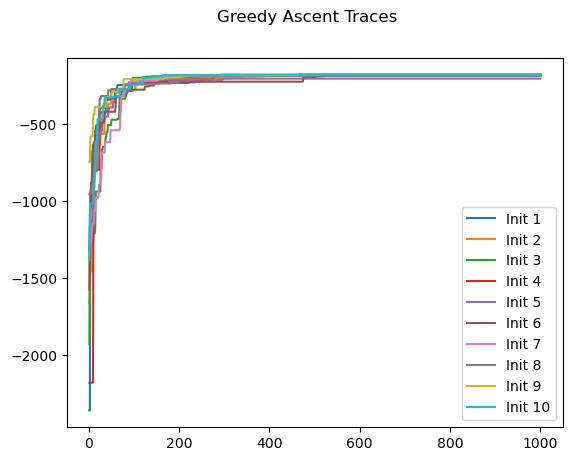

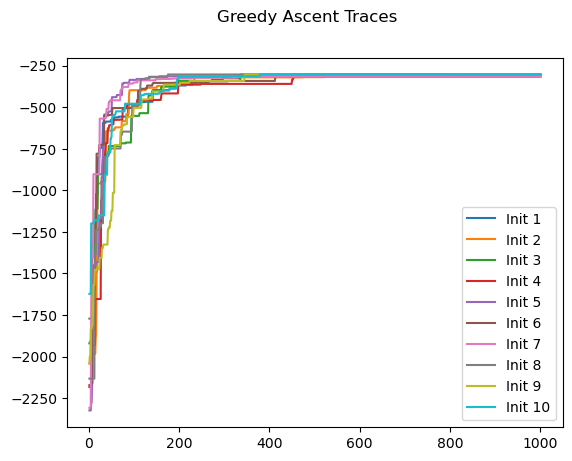

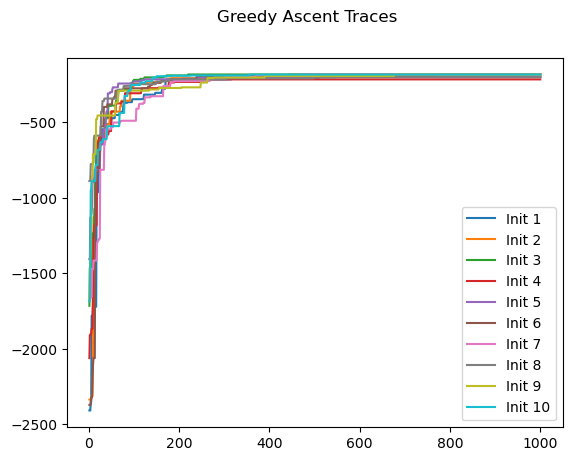

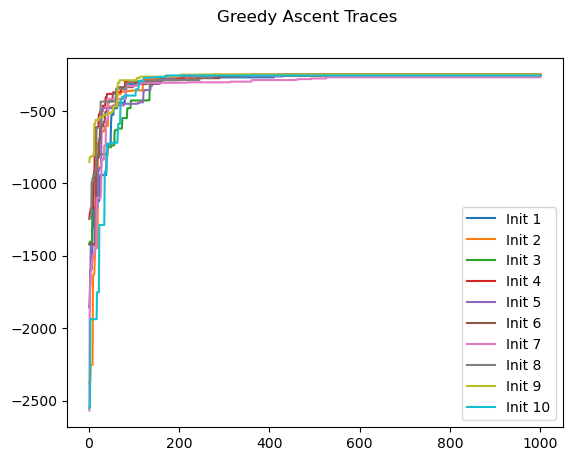

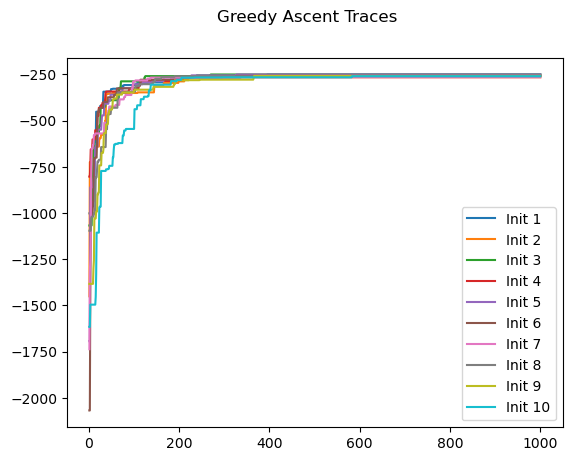

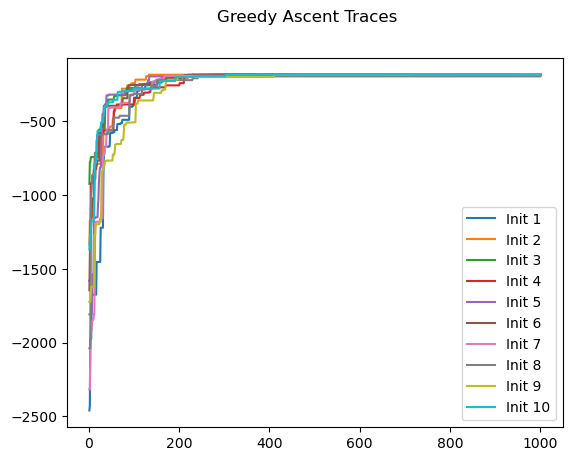

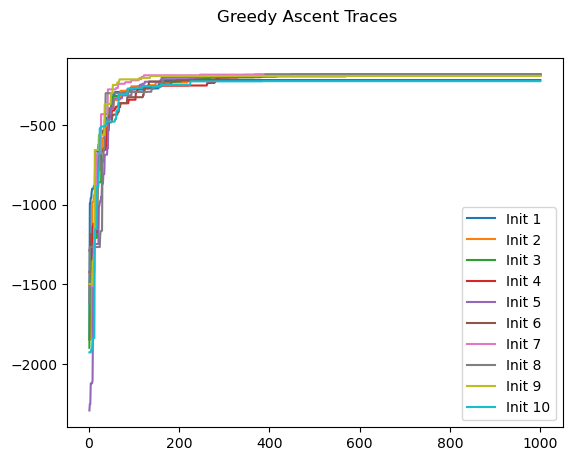

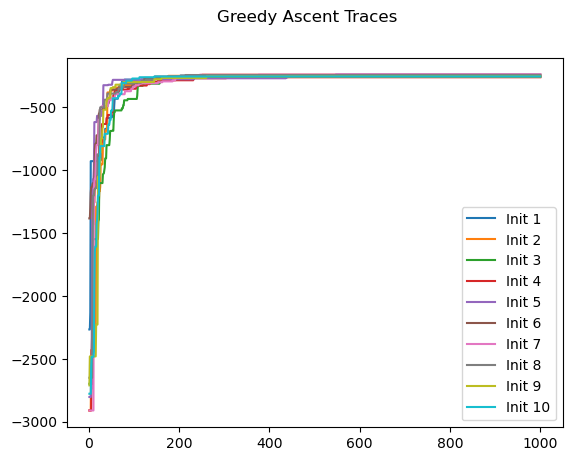

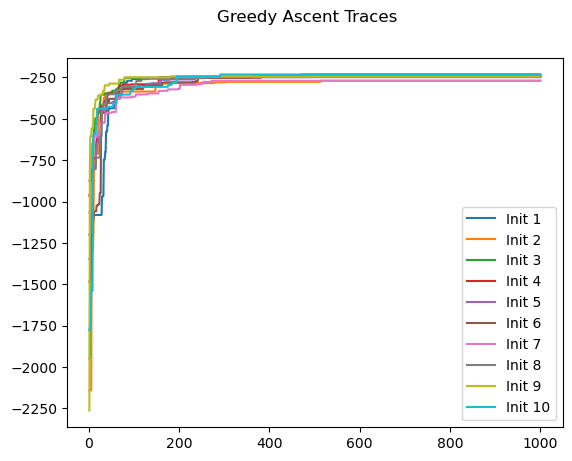

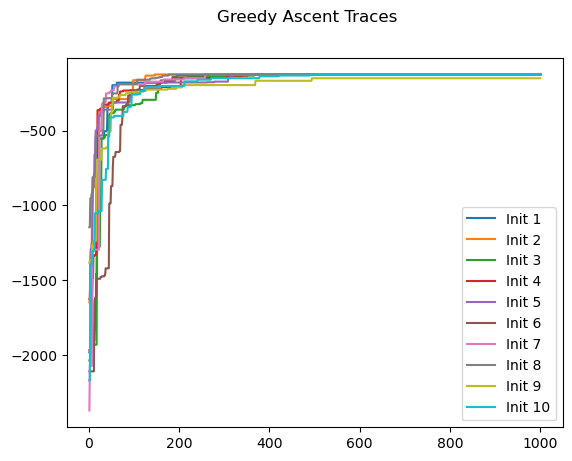

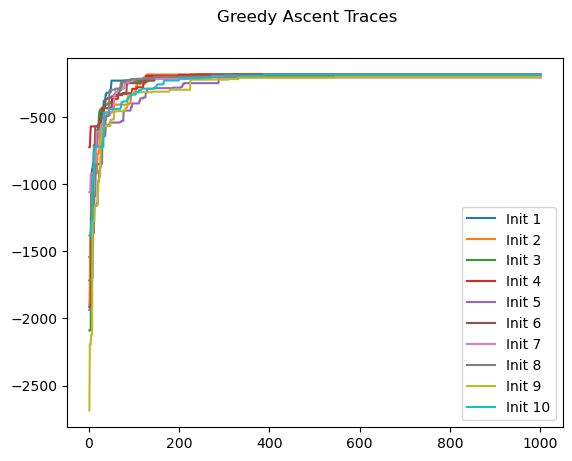

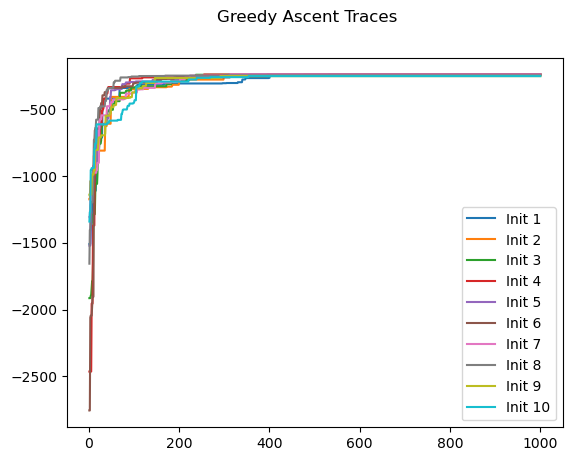

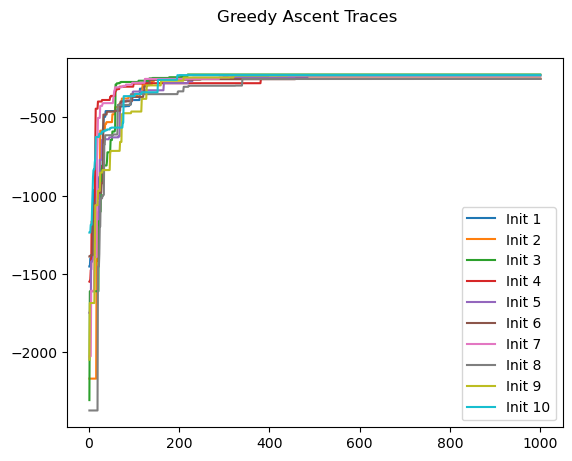

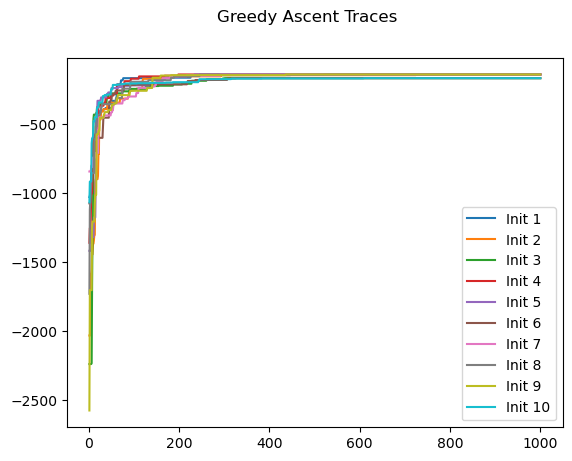

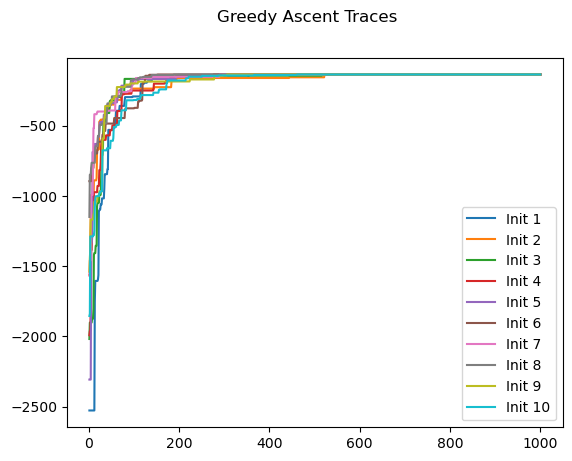

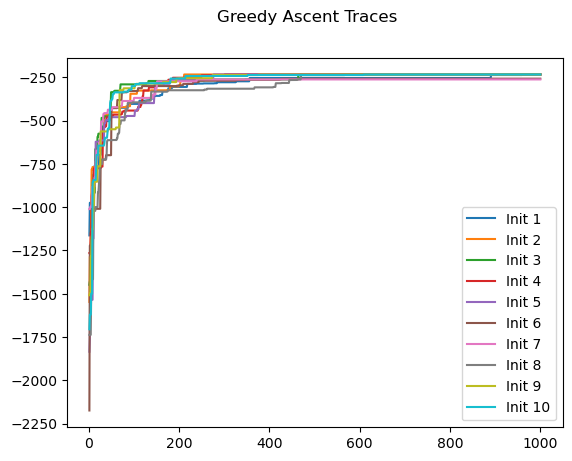

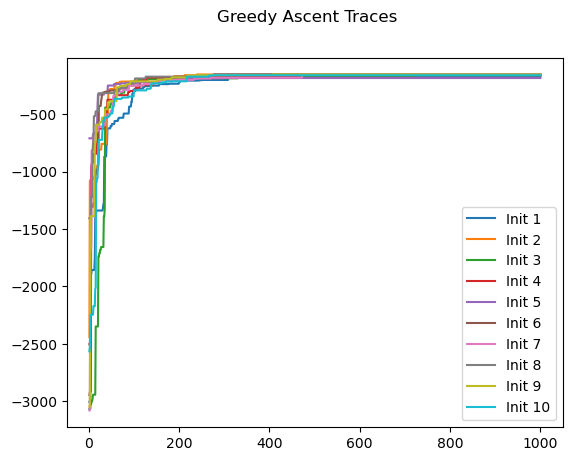

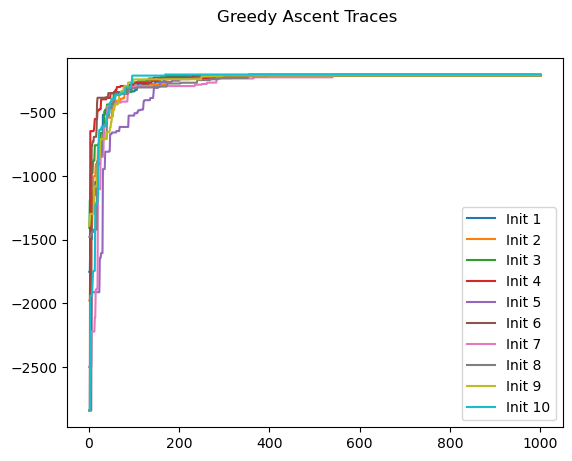

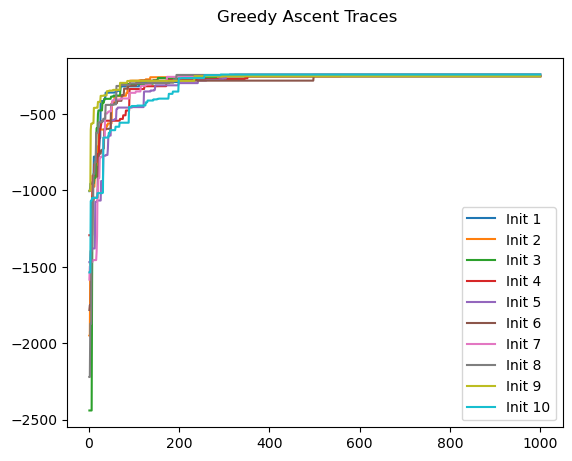

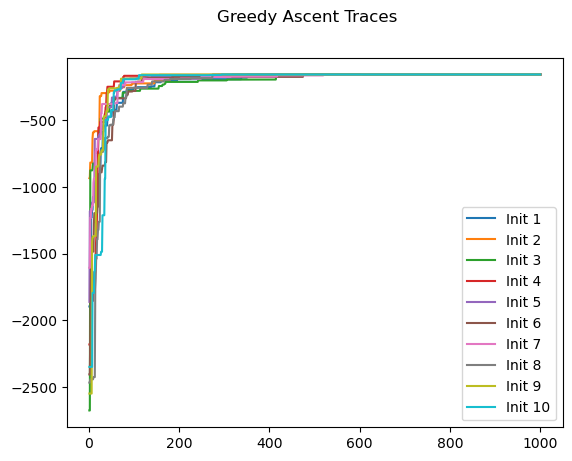

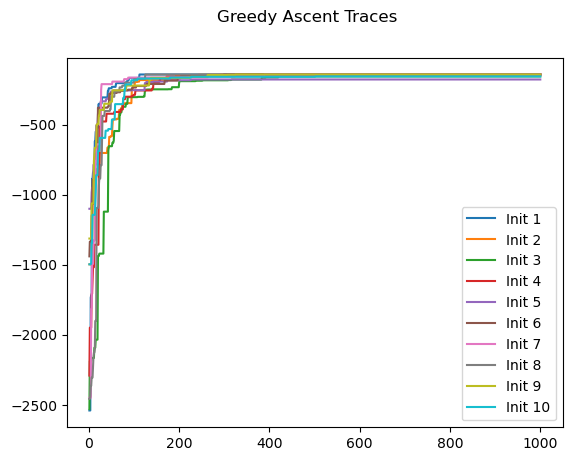

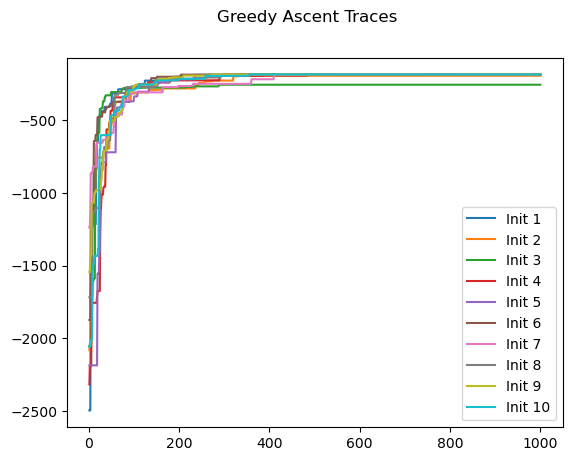

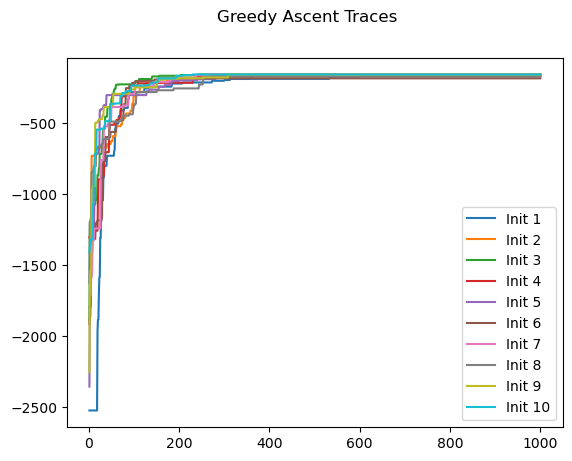

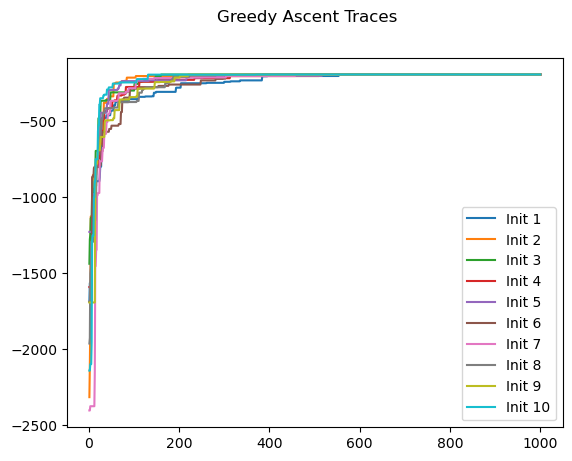

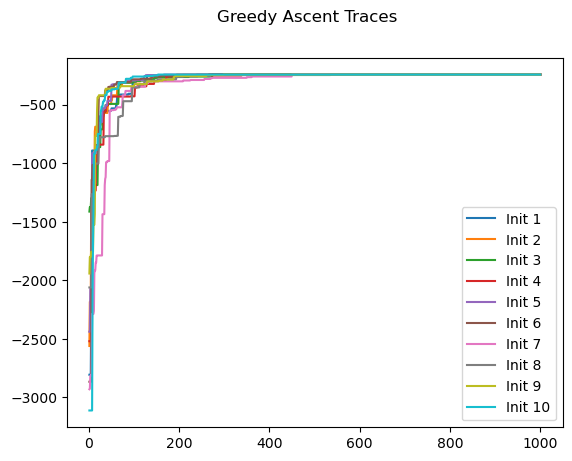

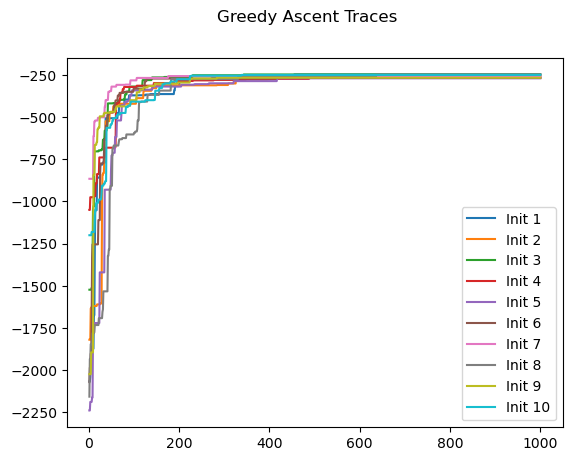

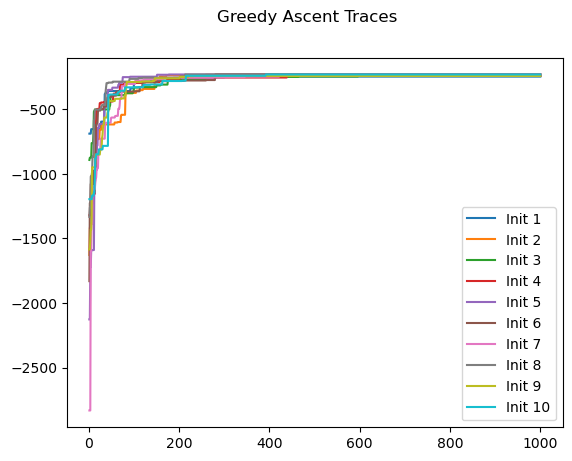

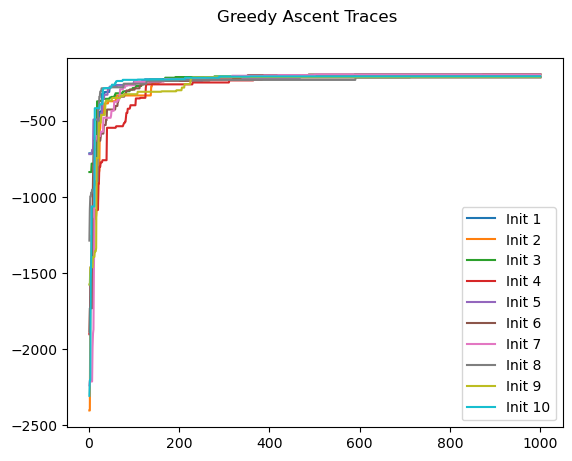

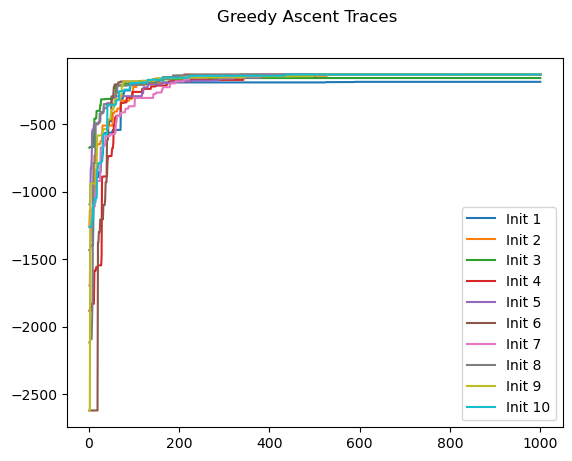

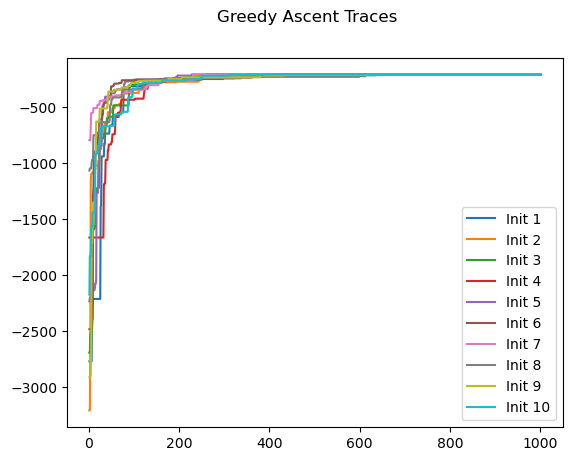

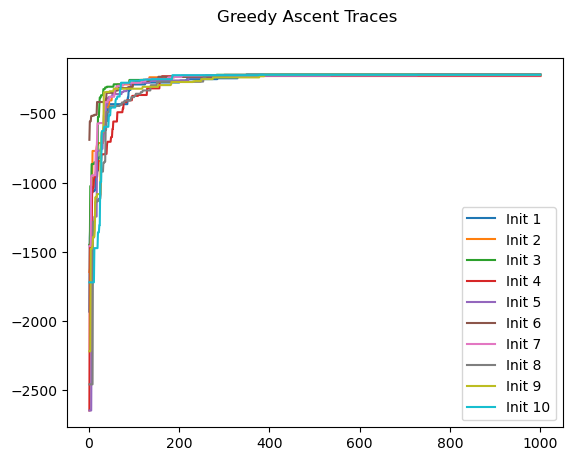

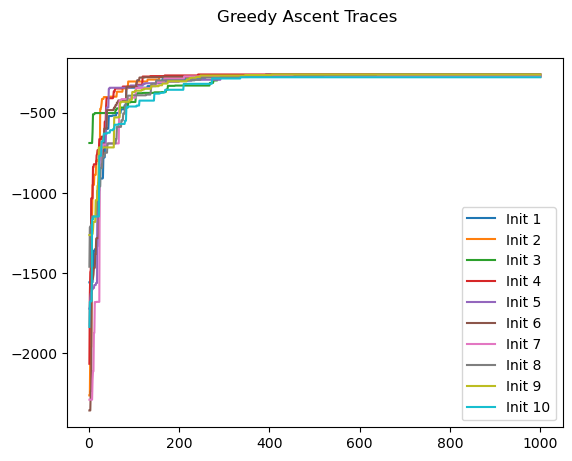

In [96]:
from sklearn.model_selection import RepeatedStratifiedKFold
#* RCV1: Repeated, stratified 5-fold CV - uses ML stage as ground truth for test folds
k_folds = 5
n_repeats = 10

#Sets up the random folds to be used in cross-validation. This just states which folds
#each individual belongs to.
repeated_cvfolds = RepeatedStratifiedKFold(n_splits=k_folds, n_repeats=n_repeats) #, random_state=36851234)

# Have we already run the EBM?
if 'ebm_results_2' in locals():
    check = True
else:
    check = False

#And if we have, have we already run the cross-validation? We can save some time
#if we already have. Otherwise, we will need to run it.
if check:
    if "mixtures_rcv" in ebm_results_2:
        kde_mixtures_rcv = ebm_results_2["mixtures_rcv"]
        mcmc_samples_rcv = ebm_results_2["mcmc_samples_rcv"]
        seqs_rcv = ebm_results_2["sequences_rcv"]
        staging_errors_rcv = ebm_results_2["staging_errors_rcv"]
        runit = False
    else:
        runit = True
else:
    runit = True

if runit:
    kde_mixtures_rcv, mcmc_samples_rcv, seqs_rcv, staging_errors_rcv = kde_utils.ebm_2_repeatedcv(
        x=df_all,
        y=codes,
        events=features,
        rcv_folds=repeated_cvfolds,
        implement_fixed_controls=True,
        patholog_dirn_array=event_disease_direction,
        model_stage=stages_long
    )
    #* Save
    ebm_results_2["mixtures_rcv"] = kde_mixtures_rcv
    ebm_results_2["mcmc_samples_rcv"] = mcmc_samples_rcv
    ebm_results_2["sequences_rcv"] = seqs_rcv
    ebm_results_2["staging_errors_rcv"] = staging_errors_rcv
    # pickle_file = open(pickle_path,'wb')
    # pickle_output = pickle.dump(ebm_results, pickle_file)
    # pickle_file.close()

Text(0.5, 0, 'Sequence')

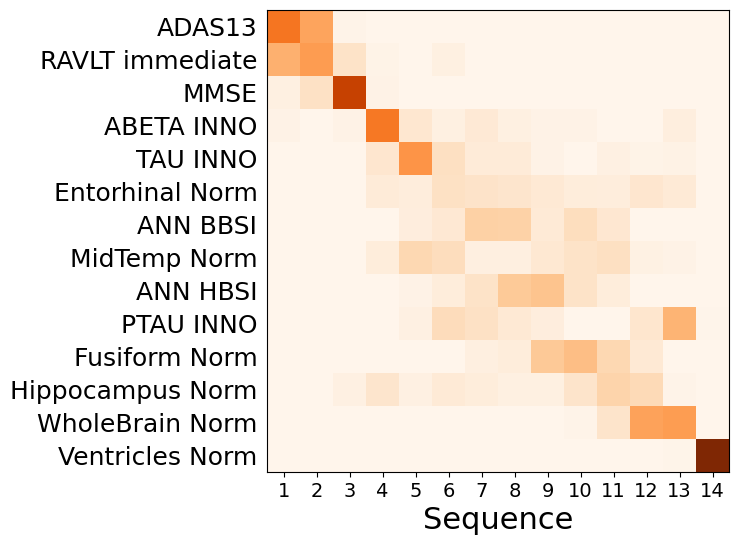

In [98]:
#* Plot EBM (PVD)
pvd_rcv, seq_rcv = kde_utils.extract_pvd(ml_order=seqs_rcv,samples=mcmc_samples_rcv)
reorder_rcv = np.argsort(seq_rcv)
pvd_rcv_ = pvd_rcv[:][reorder_rcv]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = features
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_rcv]
ax.imshow(pvd_rcv_[:][seq_rcv], interpolation='nearest', cmap='Oranges')
# ax.set_title('Cross-Validation',fontsize=24)

n_biomarkers = pvd_rcv.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0)
ax.tick_params(axis='y',color='w')
labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=18)
# ax.set_ylabel('Instrument', fontsize=28)
ax.set_xlabel('Sequence', fontsize=22)